# **Comparison between the kappa.py and wong.py modules**

This notebook contains a comparison between the module `kappa.py` and `wong.py`. The `kappa.py` module computes the momentum accumulated by a static parton, assuming that its position is fixed and the momentum changes only by virtue of the electric fields of the Glasma. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group
representation = 'fundamental'      # Fundamental or adjoint representation
boundary = 'periodic'        # Periodic boundary conditions or frozen dynamics at boundary

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 1.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 10    # Number of Glasma events
folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group
os.environ["REPRESENTATION"] = representation
os.environ["BOUNDARY"] = boundary

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
from curraun.wong import init_charge
# Kappa module
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [3]:
import pickle
from tqdm import tqdm

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
def simulate(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta
        angle = 2*np.pi*np.random.rand(1)
        p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    sigmapt_avg = np.zeros(maxt-formt)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                # Compute transverse momentum broadening
                if t==formt:
                    pmu0 = wong_solver.p.copy()
                    px0, py0 = pmu0[:, 1], pmu0[:, 2]
                pmu = wong_solver.p.copy()
                px, py = pmu[:, 1], pmu[:, 2]
                sigmapt = (px-px0)**2 + (py-py0)**2
                sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = current_path + '/' + results_folder + '/' + wong_folder + '/'
    os.chdir(wong_path)

    output['sigmapt'] = sigmapt_avg
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [4]:
quarks = ['charm', 'beauty', 'massive']
quark_masses = [1.27, 4.18, 1000]
pTs = [0.5, 5.0, 10.0]
# formation_times = [0.02, 0.08, 0]

sigmapt, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq] 
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        taus = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        sigmapts = []
        for ev in range(nevents):
            output = simulate(p, ev)
            sigmapts.append(output['sigmapt'])

        sigmapt[tag] = np.mean(sigmapts, axis=0)
        tau[tag] = taus

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['sigmapt'], output['tau'] = sigmapt, tau
filename = 'sigmapt.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Charm quark
Transverse momentum 0.5 GeV


Event 10: 100%|██████████| 409/409 [02:08<00:00,  3.19it/s]


Transverse momentum 5.0 GeV


Event 10: 100%|██████████| 409/409 [02:08<00:00,  3.19it/s]


Transverse momentum 10.0 GeV


Event 10: 100%|██████████| 409/409 [02:08<00:00,  3.19it/s]


Beauty quark
Transverse momentum 0.5 GeV


Event 10: 100%|██████████| 409/409 [02:11<00:00,  3.11it/s]


Transverse momentum 5.0 GeV


Event 10: 100%|██████████| 409/409 [03:02<00:00,  2.24it/s]


Transverse momentum 10.0 GeV


Event 10: 100%|██████████| 409/409 [02:11<00:00,  3.10it/s]


Massive quark
Transverse momentum 0.5 GeV


Event 10: 100%|██████████| 409/409 [02:13<00:00,  3.07it/s]


Transverse momentum 5.0 GeV


Event 10: 100%|██████████| 409/409 [02:13<00:00,  3.07it/s]


Transverse momentum 10.0 GeV


Event 10: 100%|██████████| 409/409 [02:13<00:00,  3.07it/s]


## Simulation routine for the static quark case

In [5]:
def simulate_kappa(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    kappa_tforce = kappa.TransportedForce(s)
    kappapt, tau =  [0], [formt*a/DTS]

    if use_cuda:
        s.copy_to_device()
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t>=formt:  

                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    px_kappa, py_kappa = kappa_tforce.p_perp_mean[0], kappa_tforce.p_perp_mean[1]
                    kappapt.append((px_kappa + py_kappa) * E0 ** 2)
                    tau.append(t*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()

                kappa_tforce.compute()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    kappa_folder = p['FOLDER']
    if not os.path.isdir(kappa_folder):
        os.makedirs(kappa_folder)
    kappa_path = current_path + '/' + results_folder + '/' + kappa_folder + '/'
    os.chdir(kappa_path)

    output['kappapt'] = kappapt
    output['tau'] = tau
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Run over multiple Glasma events and do averages

In [6]:
quarks = ['charm', 'beauty', 'massive']
quark_masses = [1.27, 4.18, 100]
pTs = [0.5, 5.0, 10.0]
# formation_times = [0.02, 0.08, 0]

kappapt, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc
    # p['TOFMR'] = formation_times[iq]

    tag = quarks[iq]
    p['FOLDER'] = su_group + '_kappa_' + quarks[iq] 

    kappapts = []
    for ev in range(nevents):
        output = simulate_kappa(p, ev)
        kappapts.append(output['kappapt'])
        tau[tag] = output['tau']

    kappapt[tag] = np.mean(kappapts, axis=0)

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['kappapt'], output['tau'] = kappapt, tau
filename = 'kappapt.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Charm quark


Event 10: 100%|██████████| 409/409 [00:05<00:00, 72.17it/s]


Beauty quark


Event 10: 100%|██████████| 409/409 [00:05<00:00, 72.00it/s]


Massive quark


Event 10: 100%|██████████| 409/409 [00:05<00:00, 71.81it/s]


## Read data from files using Julia

In [2]:
using Pickle

results = ["sigmapt", "kappapt"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "results/" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname(r,  data[r])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_sigmapt["quarks"]
pTs = string.(data_sigmapt["pTs"])

3-element Vector{String}:
 "0.5"
 "5.0"
 "10.0"

## Plot the results using Makie from Julia

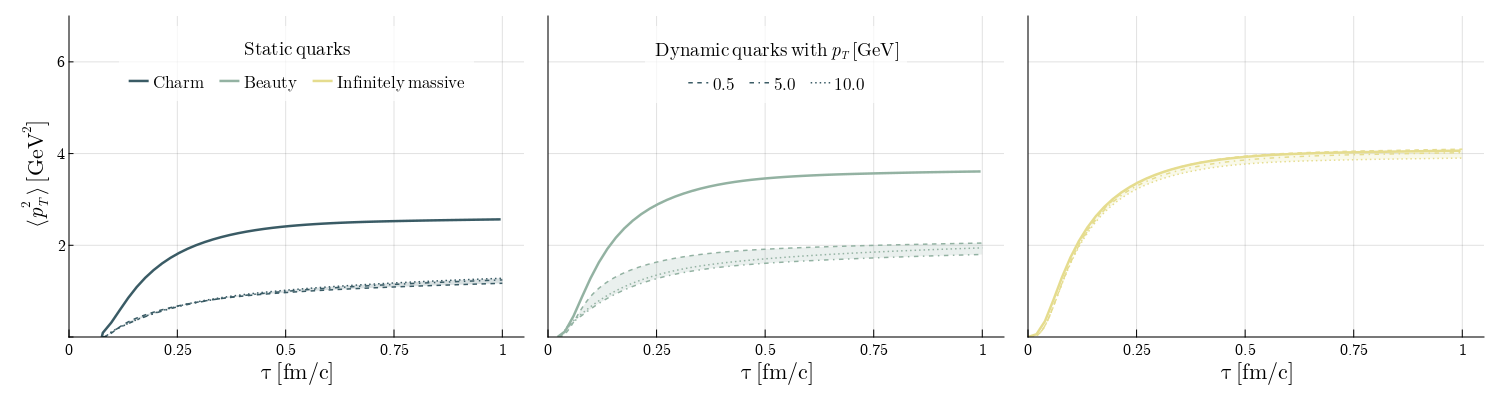

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000083dded0, 7500.0, 2000.0)


In [3]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1500, 400), font = "CMU Serif")
axes = [Axis(fig[1, i], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle p_T^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) 
     for i in 1:3]

i = 1
for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag_sigmapt = quarks[iq] * "_pT_" * pTs[ipT]
        string_as_varname("linepT"*string(i), lines!(axes[iq], tau_sigmapt[tag_sigmapt], sigmapt[tag_sigmapt], linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        i = i+1

        next_tag_sigmapt = quarks[iq] * "_pT_" * pTs[mod(ipT+1, 3)+1]
        band!(axes[iq], tau_sigmapt[tag_sigmapt], sigmapt[tag_sigmapt], sigmapt[next_tag_sigmapt]; color = (colors[iq], 0.1))
    end
    tag_kappapt = quarks[iq]
    string_as_varname("lineq"*string(iq), lines!(axes[iq], Float64.(tau_kappapt[tag_kappapt]), kappapt[tag_kappapt], linewidth = 2.5, color=colors[iq]))

    ylims!(axes[iq], 0, 7)
    xlims!(axes[iq], 0, 1.05)
    axes[iq].xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
    axes[iq].yticks = (2*(0:3), ["", "2", "4", "6"])
end

linkaxes!(axes[1], axes[2], axes[3])
hideydecorations!(axes[2], grid = false)
hideydecorations!(axes[3], grid = false)
legendq = [L"\mathrm{Charm}", L"\mathrm{Beauty}", L"\mathrm{Infinitely\,massive}"]
axislegend(axes[1], [lineq1, lineq2, lineq3], legendq, L"\mathrm{Static\,quarks}", labelsize=17, titlesize=19,
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
legendpT = [L"0.5", L"5.0", L"10.0"]
axislegend(axes[2], [linepT1, linepT2, linepT3], legendpT, L"\mathrm{Dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", labelsize=17, titlesize=19,
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("sigmapt_kappa.png", fig, px_per_unit = 5.0) 